In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/OsteoArthritis/archive.zip" -d "/content/drive/MyDrive/Colab Notebooks/OsteoArthritis/data/"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import os
import shutil
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path
import random
import pickle
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Import necessary tools
import tensorflow as tf
# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESSSS!!!!!)


In [19]:
# Configuration settings
class Config:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_epochs = 50
    num_classes = 3
    learning_rate = 1e-4
    model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
    lr_decay = 0.1
    patience = 5
    batch_size = 32
    criterion = nn.CrossEntropyLoss()

config = Config()

In [5]:
# Label mapping for the dataset
label_mapping = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2}
dataset_path = "/content/drive/MyDrive/Colab Notebooks/OsteoArthritis/data/"

In [7]:
# Function to load and preprocess data
def load_data(label_paths, label_map):
    image_paths = []
    labels = []
    for label in label_paths:
        img_list = os.listdir(f"{dataset_path}{label_paths[label]}")
        image_paths += [f"{dataset_path}{label_paths[label]}/" + p for p in img_list]
        labels += [label_map[label]] * len(img_list)
    return pd.DataFrame({"Filepath": image_paths, "Labels": labels})

In [11]:
# Load training and validation data
train_data = load_data({0: 'train/0', 2: 'train/2', 3: 'train/3', 4: 'train/4'}, label_mapping)
val_data = load_data({0: 'val/0', 2: 'val/2', 3: 'val/3', 4: 'val/4'}, label_mapping)


In [12]:
# Custom dataset class
class KneeOADataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        image = Image.open(img_name)
        label = self.df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [13]:
# Data transformations
pre_processing = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((256, 256)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'eval': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [14]:
# Create data loaders
train_loader = DataLoader(KneeOADataset(train_data, transform=pre_processing['train']), batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(KneeOADataset(val_data, transform=pre_processing['eval']), batch_size=config.batch_size)

In [ ]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    return total_loss / len(train_loader.dataset)


In [ ]:
# Model setup
model = config.model
model.fc = nn.Linear(model.fc.in_features, config.num_classes)
criterion = config.criterion
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=config.patience, factor=config.lr_decay, verbose=True)
device = config.device
model = model.to(device)
best_model_params_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/OsteoArthritis/models/', 'best_model_params.pt')


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [29]:
from sklearn.metrics import confusion_matrix


In [30]:
def validate_model(model, val_loader, criterion, device):
  model.eval()
  total_loss = 0
  preds, true_labels = [], []
  val_losses = []  # Initialize list to store validation losses
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs.data, 1)
      preds.extend(predicted.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())
      val_losses.append(loss.item() / len(inputs))  # Track loss per batch

  accuracy = accuracy_score(true_labels, preds)
  f1 = f1_score(true_labels, preds, average='weighted')
  cm = confusion_matrix(true_labels, preds)  # Calculate confusion matrix
  return total_loss / len(val_loader.dataset), accuracy, f1, val_losses, true_labels, preds, cm



In [ ]:
 # pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 16.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [ ]:
# Early Stopping callback configuration
early_stop_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0.001,  # Minimum improvement threshold
    patience=3,  # Stop training after 5 epochs without improvement
    verbose=True,  # Print information at each validation check
    mode='min'  # Track minimum validation loss
)

In [ ]:
def train_loop(epochs, model, train_loader, val_loader, optimizer, criterion, scheduler, device):
  best_acc = 0
  early_stop_count = 0
  patience = 3
  train_losses = []
  val_accuracies = []
  val_losses = []  # Initialize val_losses list here

  for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')

    # Train model
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)

    # Validate model
    val_loss, val_acc, val_f1, val_losses_ = validate_model(model, val_loader, criterion, device)
    val_losses.extend(val_losses_)  # Accumulate validation losses from batches
    val_accuracies.append(val_acc)

    # Early Stopping Logic
    if val_acc > best_acc:
      best_acc = val_acc
      torch.save(model.state_dict(), best_model_params_path)
      print('Model improved and saved')
      early_stop_count = 0
    else:
      early_stop_count += 1

    # Stop training if validation accuracy doesn't improve for 'patience' epochs
    if early_stop_count >= patience:
      print(f'Early stopping triggered after {patience} epochs without improvement')
      break

    scheduler.step(val_loss)
    print(f"Epoch {epoch + 1} - Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")

  return train_losses, val_accuracies  # Return training and validation metrics for plotting


In [ ]:
train_loop(config.num_epochs, model, train_loader, val_loader, optimizer, criterion, scheduler, device)

Epoch 1/50


100%|██████████| 74/74 [05:21<00:00,  4.35s/it]


Model improved and saved
Epoch 1 - Train loss: 0.7696, Val loss: 0.6173, Val accuracy: 0.7325, Val F1: 0.7236
Epoch 2/50


100%|██████████| 74/74 [01:07<00:00,  1.09it/s]


Epoch 2 - Train loss: 0.7224, Val loss: 0.8297, Val accuracy: 0.6716, Val F1: 0.6272
Epoch 3/50


100%|██████████| 74/74 [01:06<00:00,  1.11it/s]


Epoch 3 - Train loss: 0.6922, Val loss: 0.6992, Val accuracy: 0.7028, Val F1: 0.6675
Epoch 4/50


100%|██████████| 74/74 [01:09<00:00,  1.06it/s]


Model improved and saved
Epoch 4 - Train loss: 0.6744, Val loss: 0.5898, Val accuracy: 0.7533, Val F1: 0.7324
Epoch 5/50


100%|██████████| 74/74 [01:08<00:00,  1.09it/s]


Model improved and saved
Epoch 5 - Train loss: 0.6598, Val loss: 0.5372, Val accuracy: 0.7727, Val F1: 0.7673
Epoch 6/50


100%|██████████| 74/74 [01:08<00:00,  1.08it/s]


Epoch 6 - Train loss: 0.6330, Val loss: 0.5507, Val accuracy: 0.7652, Val F1: 0.7695
Epoch 7/50


100%|██████████| 74/74 [01:08<00:00,  1.08it/s]


Epoch 7 - Train loss: 0.6274, Val loss: 0.5646, Val accuracy: 0.7652, Val F1: 0.7580
Epoch 8/50


100%|██████████| 74/74 [01:09<00:00,  1.06it/s]


Model improved and saved
Epoch 8 - Train loss: 0.6225, Val loss: 0.5288, Val accuracy: 0.7771, Val F1: 0.7734
Epoch 9/50


100%|██████████| 74/74 [01:08<00:00,  1.08it/s]


Epoch 9 - Train loss: 0.6080, Val loss: 0.6072, Val accuracy: 0.7489, Val F1: 0.7435
Epoch 10/50


100%|██████████| 74/74 [01:09<00:00,  1.07it/s]


Model improved and saved
Epoch 10 - Train loss: 0.5943, Val loss: 0.4903, Val accuracy: 0.8098, Val F1: 0.8076
Epoch 11/50


100%|██████████| 74/74 [01:09<00:00,  1.07it/s]


Epoch 11 - Train loss: 0.5657, Val loss: 0.6322, Val accuracy: 0.7325, Val F1: 0.7386
Epoch 12/50


100%|██████████| 74/74 [01:09<00:00,  1.07it/s]


Epoch 12 - Train loss: 0.5903, Val loss: 0.6336, Val accuracy: 0.7459, Val F1: 0.7516
Epoch 13/50


100%|██████████| 74/74 [01:13<00:00,  1.00it/s]


Early stopping triggered after 3 epochs without improvement


([0.7696063952333123,
  0.7224470306430343,
  0.6921510440962655,
  0.6743607769955645,
  0.6597793535065671,
  0.6329748149857316,
  0.6273878895924037,
  0.6225333035445677,
  0.6080422957167219,
  0.5942739924937108,
  0.5657457730977694,
  0.5902754584813864,
  0.5810581303106358],
 [])

In [26]:
# Test data loading
test_data = load_data({0: 'test/0', 2: 'test/2', 3: 'test/3', 4: 'test/4'}, label_mapping)
test_loader = DataLoader(KneeOADataset(test_data, transform=pre_processing['eval']), batch_size=config.batch_size)

In [ ]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load(best_model_params_path))
test_loss, test_acc, test_f1, val_losses = validate_model(model, test_loader, criterion, device)
print(f'Test accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}')


In [ ]:
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)  # Save model state dictionary

# After training loop
save_model(model, "/content/drive/MyDrive/Colab Notebooks/OsteoArthritis/models/saved_model.pt")  # Replace "saved_model.pt" with your desired path

In [21]:
# Model setup
model = config.model
model.fc = nn.Linear(model.fc.in_features, config.num_classes)
criterion = config.criterion
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=config.patience, factor=config.lr_decay, verbose=True)
device = config.device
model = model.to(device)
best_model_params_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/OsteoArthritis/models/', 'best_model_params.pt')


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [22]:
# Replace "saved_model.pt" with your actual saved model path
model_path = "/content/drive/MyDrive/Colab Notebooks/OsteoArthritis/models/saved_model.pt"
model = config.model  # Assuming you have the model class defined in your `Config` class

# Use 'eval' transformation for consistency with training preprocessing
transform = pre_processing['eval']

# Load the model state dictionary
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
# Ensure you have already loaded the test data using `test_data` and `test_loader`
test_loss, test_acc, test_f1, test_losses, test_true_labels, test_preds, test_cm = validate_model(model, test_loader, config.criterion, config.device)

print(f'Test accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}')


Test accuracy: 0.8037, Test F1: 0.7999


In [67]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels, title, normalize=False):
  """
  Plots the confusion matrix with or without normalization.

  Args:
      cm: Confusion matrix (2D array).
      labels: List of class labels.
      title: Title for the plot.
      normalize: Boolean flag indicating normalization (True) or raw counts (False).
  """
  plt.figure(figsize=(8, 6))

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
    cmap = 'YlOrBr'  # Choose colormap for normalized values
  else:
    cmap = 'viridis'  # Choose colormap for raw counts

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]:.2f}", ha="center", va="center", fontsize=12, color="black" if cm[i, j] > 0.5 else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()

In [38]:
test_cm

array([[592,  46,   1],
       [130, 294,  23],
       [ 10,  57, 207]])

In [60]:
# Grade labels (assuming 3 classes based on test_cm dimensions)
grade_labels = ["Healthy", "Moderate", "Severe"]

# Calculate overall accuracy
accuracy = (np.trace(test_cm) / test_cm.sum()) * 100


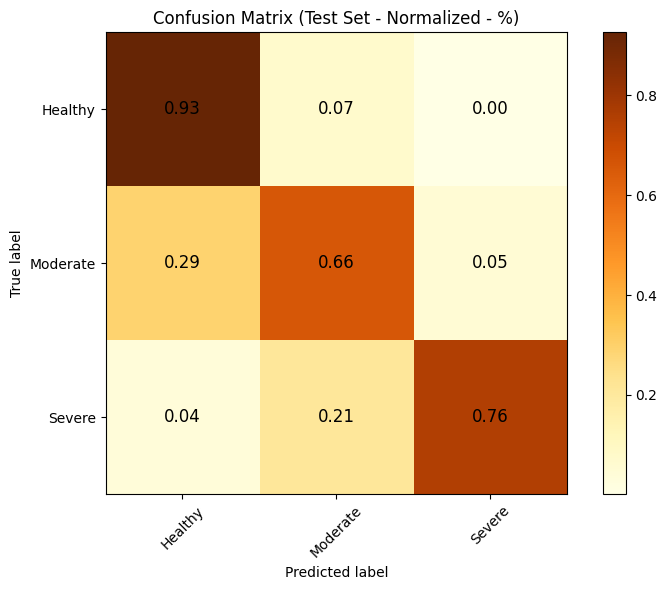

In [70]:

# Plot heatmap with normalization (showing proportions)
plot_confusion_matrix(test_cm.copy(), grade_labels.copy(), "Confusion Matrix (Test Set - Normalized - %)", normalize=True)



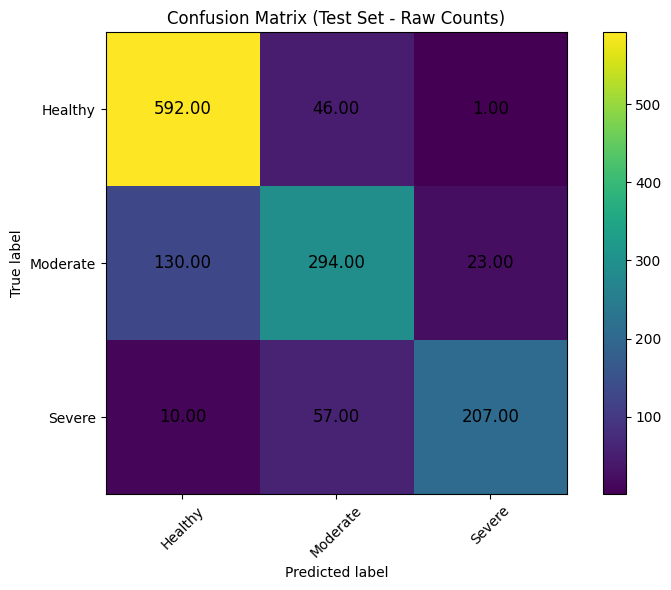

In [64]:

# Plot heatmap without normalization (showing raw counts)
plot_confusion_matrix(test_cm.copy(), grade_labels.copy(), "Confusion Matrix (Test Set - Raw Counts)", normalize=False)


In [62]:
# Print the confusion matrix
print("Confusion Matrix:\n", test_cm)

# Print the overall accuracy
print("Overall Accuracy:", accuracy, "%")

# Interpretation (example)
print("\nInterpretation:")
print("The model correctly classified", test_cm[0][0], "out of", test_cm[0].sum(), "Grade 0 (Healthy) knee images.")

Confusion Matrix:
 [[592  46   1]
 [130 294  23]
 [ 10  57 207]]
Overall Accuracy: 80.36764705882354 %

Interpretation:
The model correctly classified 592 out of 639 Grade 0 (Healthy) knee images.
